<a href="https://colab.research.google.com/github/mallickboy/carvana-car-segmentation/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python numpy matplotlib mallickboy

In [ ]:
import tensorflow as tf
import numpy as np
import glob, gc
import matplotlib.pyplot as plt
import os
from PIL import Image
# from mallickboy import runtime
from google.colab import files

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        gpu_name = details.get("device_name", "Unknown GPU")
        print(f"GPU: {gpu_name}")
else:
    print("No GPU detected.")

GPU: Tesla T4


# Initial Data collection and Processing

In [ ]:
file_name = 'kaggle.json'
if os.path.exists(file_name):
    os.remove(file_name)
files.upload()

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Move kaggle.json to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Check the permissions
!chmod 600 ~/.kaggle/kaggle.json
!chmod 600 /content/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access '/content/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c carvana-image-masking-challenge -p /content/sample_data

^C


In [ ]:
import os

# List files in the 'sample_data' directory to confirm the ZIP file
os.listdir('/content/sample_data')

['anscombe.json',
 'README.md',
 'california_housing_test.csv',
 'california_housing_train.csv',
 'mnist_test.csv',
 'mnist_train_small.csv']

In [ ]:
!unzip /content/sample_data/carvana-image-masking-challenge.zip -d /content/sample_data/carvana

Archive:  /content/sample_data/carvana-image-masking-challenge.zip
  inflating: /content/sample_data/carvana/29bb3ece3180_11.jpg  
  inflating: /content/sample_data/carvana/metadata.csv.zip  
  inflating: /content/sample_data/carvana/sample_submission.csv.zip  
  inflating: /content/sample_data/carvana/test.zip  
  inflating: /content/sample_data/carvana/test_hq.zip  
  inflating: /content/sample_data/carvana/train.zip  
  inflating: /content/sample_data/carvana/train_hq.zip  
  inflating: /content/sample_data/carvana/train_masks.csv.zip  
  inflating: /content/sample_data/carvana/train_masks.zip  


### Temporary loaction of image

In [ ]:
path_image = '/content/sample_data/carvana/train'
path_mask = '/content/sample_data/carvana/train_masks'

# Accessing Stored Data from Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive/Colab Notebooks')

['csc602Assignment1',
 'csc602Assignment2',
 'csc612Assignment3',
 'csc612Assignment4',
 'Untitled (1)',
 'csc612Assignment5',
 'csc612Assignment6',
 'csc612Assignment7',
 'Copy of 759_csc612_assignment7.ipynb',
 'csc612Test1',
 'csc612Assignment8',
 'csc612Assignment9',
 'csc612Assignment10',
 'csc612Assignment11',
 'csc612Assignment12',
 'test2',
 '6_sem_project',
 'Untitled0.ipynb',
 'Untitled',
 'Untitled1.ipynb',
 'BigVision_task.ipynb',
 'BigVision.ipynb',
 'data']

#### Re-using saved Train, Validation, Test data from drive (created useing sezie_store_image function)

In [ ]:
DIR= '/content/drive/MyDrive/Colab Notebooks/data/'
# import zipfile
# with zipfile.ZipFile(DIR+"split.zip", 'r') as zip_ref:
#     zip_ref.extractall(DIR)
# os.listdir(DIR)

['split.zip', 'test', 'train', 'valid']

#### Observing Images

This folder has  3552  files
/content/drive/MyDrive/Colab Notebooks/data/train/image/0795e132d090_15.jpg
Image shape: (256, 256, 3)


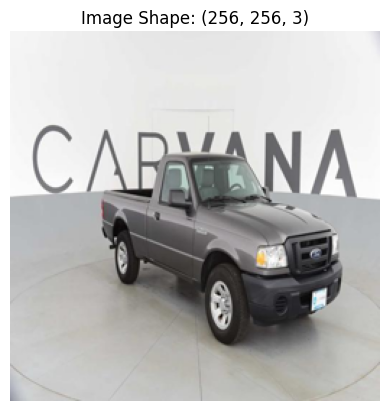

This folder has  3552  files
/content/drive/MyDrive/Colab Notebooks/data/train/mask/0795e132d090_15_mask.gif
Image shape: (256, 256)


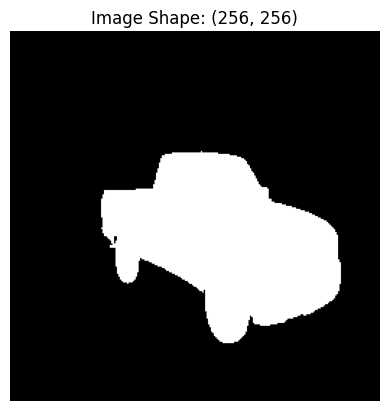

In [ ]:
def show_image(path):
    image_files = [file for file in os.listdir(path) if file.endswith('.jpg') or file.endswith('.gif') ]
    print("This folder has ",len(image_files)," files")
    image_path = os.path.join(path, image_files[110])
    image = Image.open(image_path)

    image = image.resize((256, 256))
    image_array = np.array(image)
    print(image_path)
    print(f"Image shape: {image_array.shape}")

    plt.imshow(image)
    plt.title(f"Image Shape: {image_array.shape}")
    plt.axis('off')  # Hide axes
    plt.show()

show_image(DIR+"train/image/")
show_image(DIR+"train/mask/")

#### Resize and store Images

In [ ]:
def resize_store_image(source_dir, destination_dir, new_size=(256, 256)):
    image_file_all= [file for file in os.listdir(source_dir) if file.endswith(".jpg") or file.endswith(".gif")]

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for file_name in image_file_all[:]:
        path_abs= os.path.join(source_dir, file_name)

        image= Image.open(path_abs)
        image_resized= image.resize(new_size)

        destination_path_abs= os.path.join(destination_dir, file_name)

        image_resized.save(destination_path_abs)
        # print(path_abs, destination_path_abs)
    print("Resized and saved to : ", destination_dir)

# resize_store_image(path_image, "./data/image", (512, 512))
# resize_store_image(path_mask, "./data/mask", (512, 512))

In [ ]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/data.zip'
extracted_path = '/content/drive/MyDrive/Colab Notebooks/data/'

path_image= '/content/drive/MyDrive/Colab Notebooks/data/train/image'
path_mask= '/content/drive/MyDrive/Colab Notebooks/data/train/mask'

DIR= '/content/drive/MyDrive/Colab Notebooks/data/'

#### Unzipping Saved Files

In [ ]:
# import zipfile
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_path)
# os.listdir(extracted_path)

['data']

### Observing the Train image

This folder has  3552  files
/content/drive/MyDrive/Colab Notebooks/data/train/image/0795e132d090_15.jpg
Image shape: (256, 256, 3)


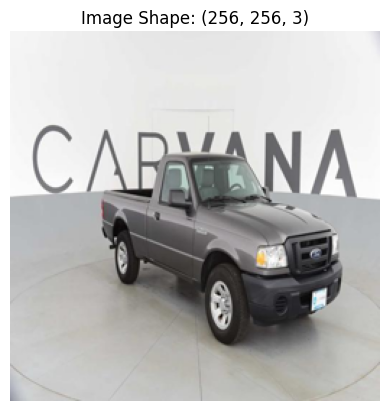

This folder has  3552  files
/content/drive/MyDrive/Colab Notebooks/data/train/mask/0795e132d090_15_mask.gif
Image shape: (256, 256)


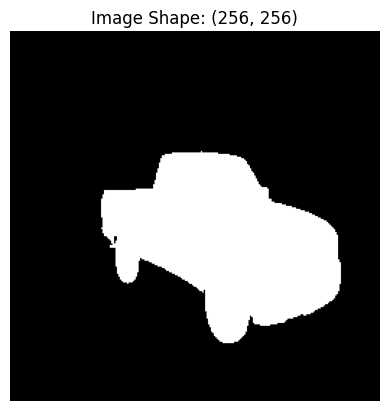

In [ ]:
image_files = [file for file in os.listdir(path_image) if file.endswith('.jpg') ]
mask_files = [file for file in os.listdir(path_mask) if file.endswith('.gif') ]

show_image('/content/drive/MyDrive/Colab Notebooks/data/train/image')
show_image('/content/drive/MyDrive/Colab Notebooks/data/train/mask')

#### Understanding pattern of image data

Image : /content/drive/MyDrive/Colab Notebooks/data/train/image/00087a6bd4dc_01.jpg


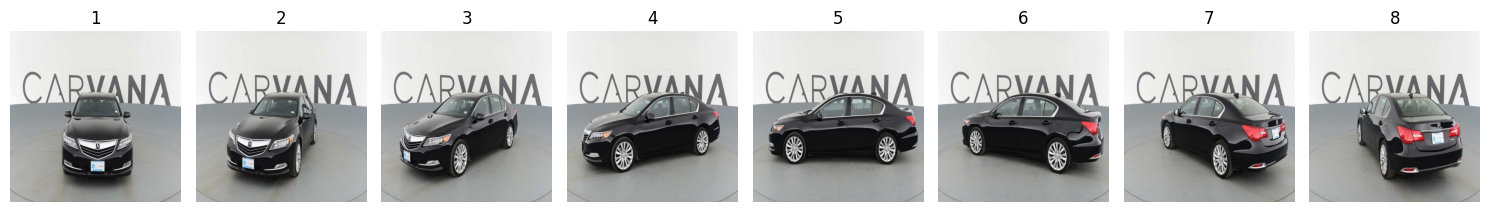

Image : /content/drive/MyDrive/Colab Notebooks/data/train/image/00087a6bd4dc_02.jpg


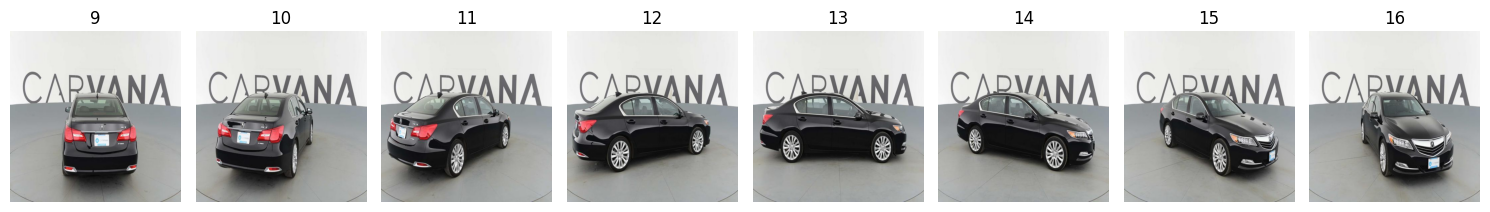

Image : /content/drive/MyDrive/Colab Notebooks/data/train/image/00087a6bd4dc_03.jpg


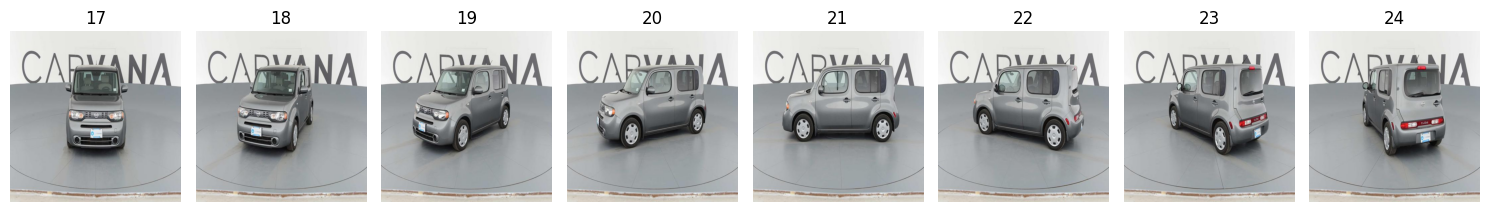

In [ ]:
def show_image_adv(path, row=1, column=8, random_=False):
    image_files = [file for file in os.listdir(path) if file.endswith('.jpg') or file.endswith('.gif') ]
    image_files.sort()
    def get_ind(i):
        return np.random.randint(0,len(image_files)) if random_ else i

    for i in range(row):
        fig, axes= plt.subplots(1,column, figsize=(15, 10))
        image = Image.open(os.path.join(path, image_files[get_ind(i)]))
        print(f"Image : {os.path.join(path, image_files[get_ind(i)])}")
        for j, ax in enumerate(axes):
            indx= get_ind(i*column+ j)
            ax.set_title(str(indx+ 1))
            ax.set_axis_off()
            img= Image.open( os.path.join(path, image_files[indx]) )

            # img = img.transpose(Image.FLIP_TOP_BOTTOM)

            ax.imshow(img)
        plt.tight_layout()
        plt.show()

show_image_adv(path_image, row=3, column=8, random_=False)

### Idea of spilt and Agumentation

##### If we plot the sorted image we can see these are time series images from different angels (16 for each car):
1. Need to maintain complete isolation of test data so the model has zero exposure to it.
2. The validation set should also contain unseen images to help in generalization before testing.
3. Splitting strategy :
    - I will follow 70% train, 15% valid, 15% test
    - Then apply augmentation on the training set by 1.5x to improve diversity while avoiding redundancy.
    - Now we have 70 * 1.5 = 10 augmented training images (from the original 70%).
    - Keep the raw, unseen validation data = 15 images (to avoid augmentation inflating validation performance).
    - Keep 15 images for testing (unexposed to the model).
    - Total images = (105 + 15 + 15) = 135.
    - Final ratio around : **( 78% Train : 11% Valid : 11% Test)**  

##### Idea behind augumentation
Since 16 images for each car have been collected from different angles, some form of augmentation has already been done at the data collection level. Therefore, X and Y axis flips, as well as rotations, are not required.
1. Brightness & Contrast Adjustments
2. Zoom In/Out
3. Shear Transformations
4. Gaussian Noise
5. minor color variations
6. Motion Blur for edge defination
7. Avoided X, Y flips as we are dealing with time series images of cars, which makes them unnecessary.

# Performing Train, Validation & Test split ( 70: 15: 15 )
  This data will be reused later

In [ ]:
def train_valid_test_split(features, labels, dir, ratio=(70, 15, 15), row=16, matrix=(512, 512)):

    assert sum(ratio) == 100, "ratios must sum up to 100"

    destination=[]
    for split in ["train", "valid", "test"]:    # creating directories
        img, mask= os.path.join(dir, split, "image"), os.path.join(dir, split, "mask")
        x=os.makedirs(img, exist_ok=True)
        os.makedirs(mask, exist_ok=True)
        destination.append((img, mask))

    frem, lrem, count, missed= len(features.split("*")[-1]), len(labels.split("*")[-1]), 0, 0
    features, labels= sorted(glob.glob(features)), sorted(glob.glob(labels))    # getting image paths
    print(f"Features : {len(features)}, Labels : {len(labels)}")

    for i, (feature, label) in enumerate(zip(features, labels)):    # validating the correct names for img mask pair
        feature_name, label_name=feature.split("/")[-1][:-frem], label.split("/")[-1][:-lrem]
        if feature_name != label_name:
            missed +=1
            continue
        count +=1
    print(f"Found {count} valid (feature/ label) pairs ")
    column= count// row
    distribution=[round(x* column/100)  for x in ratio]
    if sum(distribution) != column:
        distribution[0]-= sum(distribution)- column
    print(f"Distributions: {distribution}, sum : {sum(distribution)}")

    start= 0
    for chunk, folder in zip(distribution, destination):
        num=0
        for ind in range(start, start+ chunk* row):
            num+=1
            if True:
                f, l = features[ind], labels[ind]
                img_dir, mask_dir= os.path.join(folder[0], f.split("/")[-1]), os.path.join(folder[1], l.split("/")[-1])
                # print(f, l, img, mask)
                fimage, limage= Image.open(f).resize(matrix), Image.open(l).resize(matrix)
                fimage.save(img_dir)
                limage.save(mask_dir)
        start= start+ chunk* row
        print(num, ind)
    print(f"Processed : {count} pair (image/ mask) & Missed : {missed} pairs (image/ mask)")

# path_image= '/content/drive/MyDrive/Colab Notebooks/data/data/image'
# path_image= '/content/drive/MyDrive/Colab Notebooks/data/data/mask'
# train_valid_test_split(path_image+"/*.jpg", path_mask+"/*_mask.gif", dir=DIR, ratio=(70, 15, 15) )

### Processing Mask
Converting pixel values to 0 or 1 for segmentation

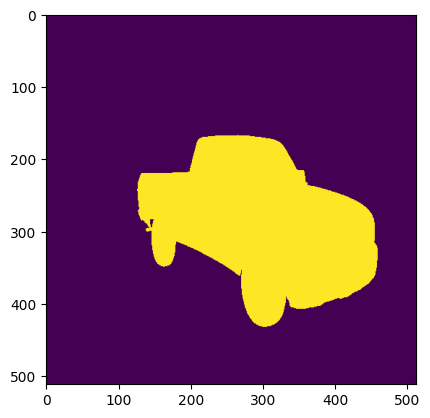

In [ ]:
def process_mask(mask_path):
    mask = Image.open(mask_path).convert("L")  # to grayscale
    mask = np.array(mask)
    mask = (mask > 128).astype(np.uint8)  # converting to binary (0 and 1)
    plt.imshow(mask)

process_mask("/content/drive/MyDrive/Colab Notebooks/data/train/mask/0795e132d090_15_mask.gif")

# Now Performing Augumentation

In [ ]:
import cv2
import albumentations as A
AUGMENTATIONS = {
    "Brightness/Contrast": A.RandomBrightnessContrast(p=1),
    "Zoom": A.RandomScale(scale_limit=0.3, p=1),
    "Shear": A.Affine(shear=20, p=1),
    "Gaussian Noise": A.GaussNoise(var_limit=(10, 50), p=1),
    "Color Shift": A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, p=1),
    "Motion Blur": A.MotionBlur(blur_limit=5, p=1)
}

<ipython-input-23-ac49e8884637>:7: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  "Gaussian Noise": A.GaussNoise(var_limit=(10, 50), p=1),


#### Checking augmentations

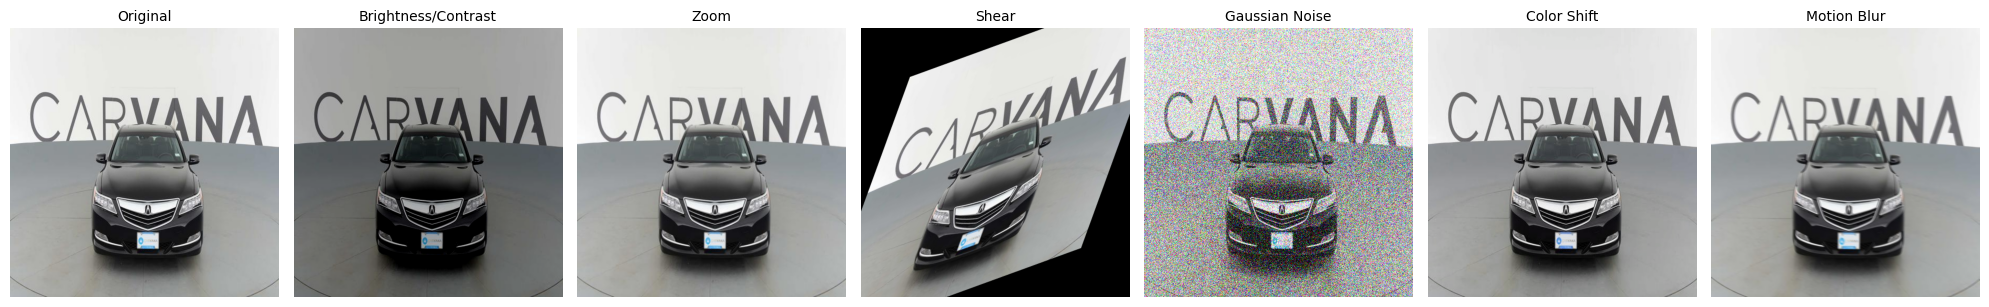

In [ ]:
def plot_images(images, titles, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(title, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def apply_augmentations(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed_images = [image]  # orininal image
    titles = ["Original"]

    for name, transform in AUGMENTATIONS.items():
        augmented = transform(image=image)["image"]
        transformed_images.append(augmented)
        titles.append(name)

    plot_images(transformed_images, titles)

apply_augmentations(DIR+"/train/image/00087a6bd4dc_01.jpg")

##### Checking Augmentations that change the structures on image
So for those only I have to augument the mask/label accordingly to avoid confusion for model

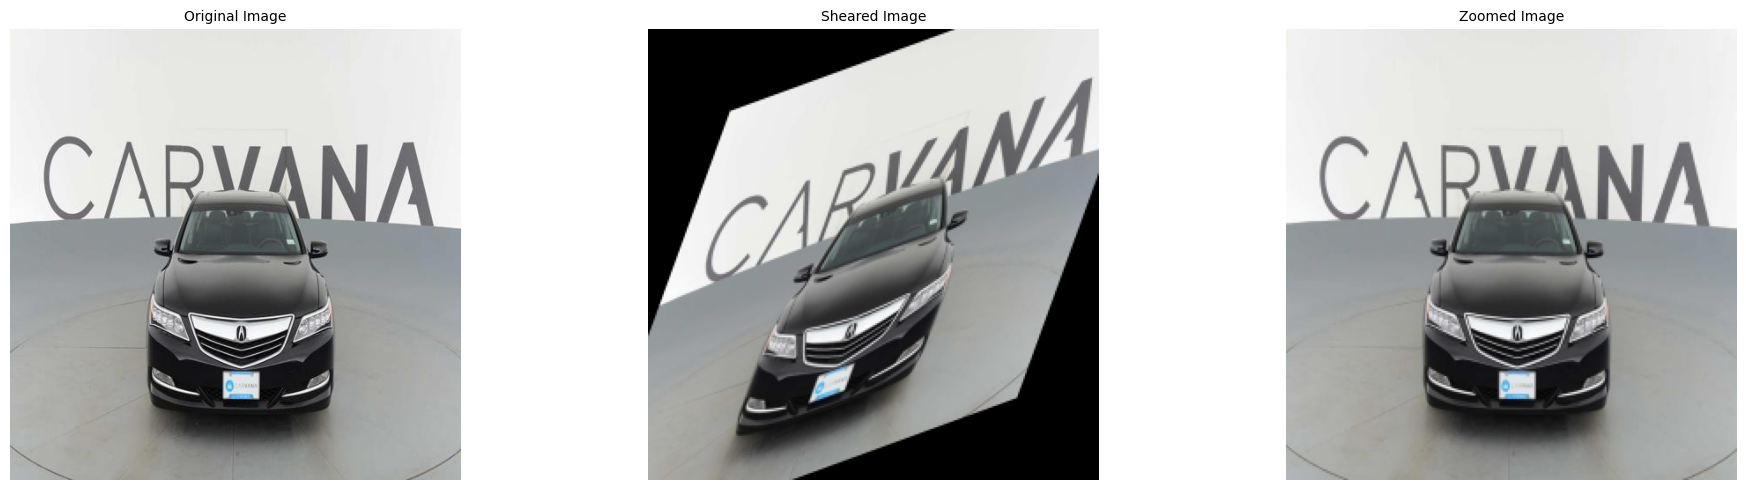

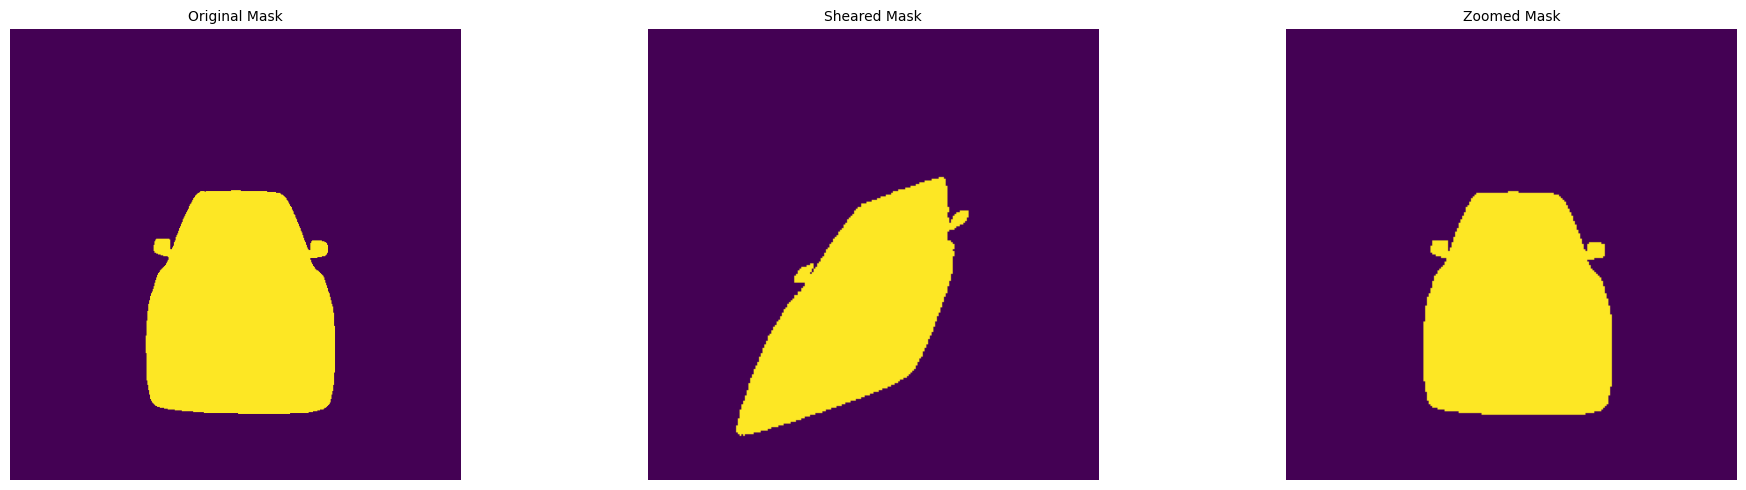

In [ ]:
def apply_augmentations(image_path, mask_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = Image.open(mask_path).convert("L")  # converting to grayscale
    mask = np.array(mask)

    if "Shear" in AUGMENTATIONS and "Zoom" in AUGMENTATIONS:
        shear_transform = A.Compose([AUGMENTATIONS["Shear"], A.Resize(256, 256)  ])(image=image, mask=mask)
        zoom_transform = A.Compose([AUGMENTATIONS["Zoom"],  A.Resize(256, 256)  ])(image=image, mask=mask)

        img_shear, mask_shear = shear_transform["image"], shear_transform["mask"]
        img_zoom, mask_zoom = zoom_transform["image"], zoom_transform["mask"]
    plot_images([image, img_shear, img_zoom], ["Original Image", "Sheared Image", "Zoomed Image"])
    plot_images([mask, mask_shear, mask_zoom], ["Original Mask", "Sheared Mask", "Zoomed Mask"])

apply_augmentations(DIR+"/train/image/00087a6bd4dc_01.jpg", DIR+"/train/mask/00087a6bd4dc_01_mask.gif")


# Numpy array creation for Train, Validation & Test Data (with Data Augmentation)

In [ ]:
def preprocess_data_augmentation_shuffle(features, labels, fshape, lshape, aug_ratio=0.5, augment=False, limit=float("inf")):
    frem, lrem, count, missed = len(features.split("*")[-1]), len(labels.split("*")[-1]), 0, 0
    features, labels = sorted(glob.glob(features)), sorted(glob.glob(labels))
    limit = min(len(features), len(labels), limit)

    num_samples = int(limit * ((1 + aug_ratio) if augment else 1))  # only needed for training
    num_augment = int(len(features) * aug_ratio)
    augment_indices = set(np.random.choice(len(features), num_augment, replace=False))

    data_xx, data_yy = np.zeros((num_samples, *fshape), dtype=np.float32), np.zeros((num_samples, *lshape), dtype=np.float32)
    print("Numpy array shape:", data_xx.shape, data_yy.shape)

    i, aug_done = 0, 0
    for feature, label in zip(features, labels):
        try:
            # if i >= limit: break

            feature_name, label_name = feature.split("/")[-1][:-frem], label.split("/")[-1][:-lrem]
            if feature_name != label_name:
                missed += 1
                continue

            f_img = Image.open(feature).resize((fshape[1], fshape[0]))  # loading and resizing images
            l_img = Image.open(label).convert("L").resize((lshape[1], lshape[0]))  # converting to standard 256 bit color

            # image to numpy array for next steps
            f_array = (np.array(f_img, dtype=np.float32) / 255.0).astype(np.float32)  # normalizing feature images to [0, 1]
            l_array = (np.array(l_img, dtype=np.float32) / 255.0 > 0.5).astype(np.uint8)  # converting to binary (0 and 1)

            data_xx[i, :, :, :] = f_array.astype(np.float32)  # adding the original image
            data_yy[i, :, :, 0] = l_array.astype(np.uint8)  # adding the original mask
            original_idx = count
            i += 1
            count += 1  # Increase original dataset counter

            if augment and original_idx in augment_indices:  # augment exactly on 50% of images (aug_ratio)
                aug = np.random.choice(list(AUGMENTATIONS.keys()))
                transform = A.Compose([
                    AUGMENTATIONS[aug],
                    A.Resize(fshape[0], fshape[1])  # resizing to (256, 256) as randomScale and affine can change the matrix size
                ])

                if aug in ["Shear", "Zoom"]:  # as shear and zoom changes the structure so need to replicate same on mask also
                    transformed = transform(image=f_array, mask=l_array)
                    f_aug, l_aug = transformed["image"], transformed["mask"]
                else:
                    f_aug = transform(image=f_array)["image"]
                    l_aug = l_array  # keeping original mask , as structure is intact

                data_xx[i, :, :, :] = f_aug.astype(np.float32)
                data_yy[i, :, :, 0] = l_aug.astype(np.uint8)
                i += 1
                aug_done += 1
        except:
            pass  # Skip this feature-label pair if error occurs

    np.random.seed(42)
    indices = np.arange(i)
    np.random.shuffle(indices)
    data_xx, data_yy = data_xx[indices], data_yy[indices]
    print(f"\tTotal: {len(data_xx[:i])} Original: {len(features)}, Augmentations Added: {aug_done}, Missed: {len(features)-len(data_xx[:i])}\n")

    return data_xx[:i], data_yy[:i]  # removing excess space

In [ ]:
import gc
DIR

'/content/drive/MyDrive/Colab Notebooks/data/'

In [ ]:
def cost_estimation_ram(shape):
    cost= 4 #  np.float32 takes 4 Bytes
    for val in shape: cost*= val
    print( f" Shape : {shape}\trequires : {round(cost/1000_000_000, 2)} GB RAM")
cost_estimation_ram(shape=(5328, 512, 512, 4))      # feature + label
cost_estimation_ram(shape=(5328, 256, 256, 4))      # feature + label
cost_estimation_ram(shape=(5328, 128, 128, 4))      # feature + label

 Shape : (5328, 512, 512, 4)	requires : 22.35 GB RAM
 Shape : (5328, 256, 256, 4)	requires : 5.59 GB RAM
 Shape : (5328, 128, 128, 4)	requires : 1.4 GB RAM


#### Creating Numpy Arrays ( Train, Validation & Test ) for Next steps
Also for colab I can use (128, 128) shape only higher is not affordable considering the RAM . As multiple copy of data, models need be stored and also need some extra temporary space for data shuffeling and training

In [ ]:
gc.collect()
TRAIN_XX, TRAIN_YY= preprocess_data_augmentation_shuffle(
    DIR+"/train/image/*.jpg",
    DIR+"/train/mask/*_mask.gif",
    fshape=(128, 128, 3), lshape=(128, 128, 1)
    ,augment=True, aug_ratio=0.5)   # augmenting the train set only

Numpy array shape: (5328, 128, 128, 3) (5328, 128, 128, 1)
	Total: 5328 Original: 3552, Augmentations Added: 1776, Missed: -1776



In [ ]:
gc.collect()
VALID_XX, VALID_YY= preprocess_data_augmentation_shuffle(
    DIR+"/valid/image/*.jpg",
    DIR+"/valid/mask/*_mask.gif",
    fshape=(128, 128, 3), lshape=(128, 128, 1)
    ,augment=False, aug_ratio=0)

Numpy array shape: (768, 128, 128, 3) (768, 128, 128, 1)
	Total: 768 Original: 768, Augmentations Added: 0, Missed: 0



In [ ]:
gc.collect()
TEST_XX, TEST_YY= preprocess_data_augmentation_shuffle(
    DIR+"/test/image/*.jpg",
    DIR+"/test/mask/*_mask.gif",
    fshape=(128, 128, 3), lshape=(128, 128, 1)
    ,augment=False, aug_ratio=0)


Numpy array shape: (768, 128, 128, 3) (768, 128, 128, 1)
	Total: 768 Original: 768, Augmentations Added: 0, Missed: 0



In [ ]:
total= len(TRAIN_XX)+ len(VALID_XX)+ len(TEST_XX)
print(f"Train : {round(len(TRAIN_XX)/total*100, 1)} %\tValid : {round(len(VALID_XX)/total*100, 1)} %\tTest : {round(len(TEST_XX)/total*100, 1)} %\t")

Train : 77.6 %	Valid : 11.2 %	Test : 11.2 %	


## Re-checking the final data before feeding it to the model

Total data :  5328
Total data :  768
Total data :  768


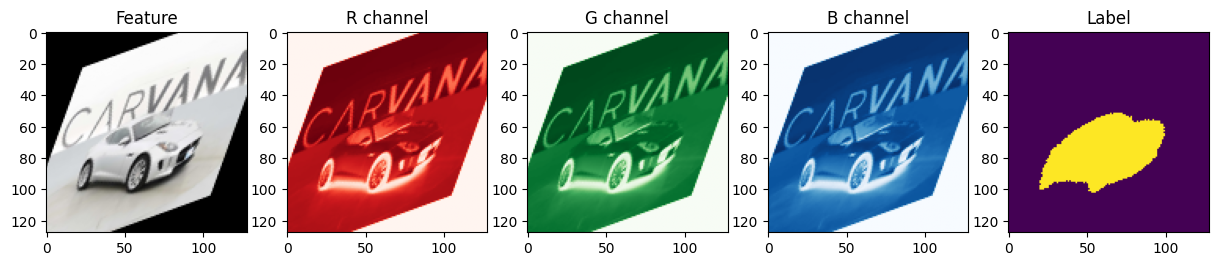

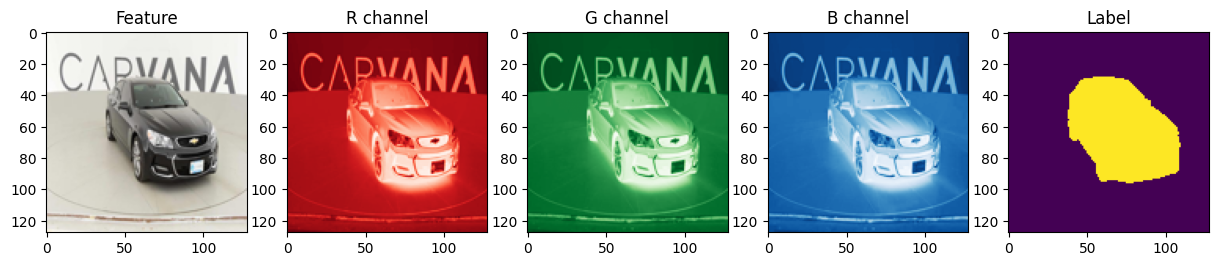

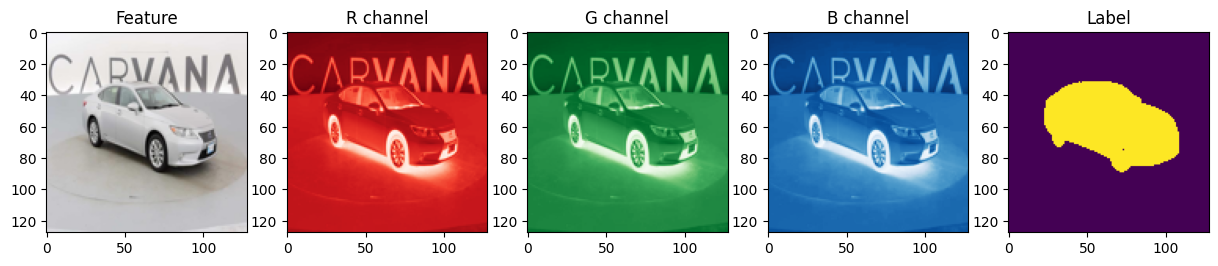

In [ ]:
def check_final_data(xx, yy, image=1):
    if len(xx)==len(yy):
        print("Total data : ",len(xx) )

        for i in range(image):
            ind= np.random.randint(0,len(xx))
            fig, (ax1, ax2, ax3, ax4, ax5)= plt.subplots(1,5, figsize=(15, 10))
            ax1.set_title("Feature")
            ax2.set_title("R channel")
            ax3.set_title("G channel")
            ax4.set_title("B channel")
            ax5.set_title("Label")
            ax1.imshow(xx[ind])
            ax2.imshow(xx[ind,:, :,0], cmap='Reds')
            ax3.imshow(xx[ind,:, :,1], cmap='Greens')
            ax4.imshow(xx[ind,:, :,2], cmap='Blues')
            ax5.imshow(yy[ind])

check_final_data(TRAIN_XX, TRAIN_YY, image=1)
check_final_data(VALID_XX, VALID_YY)
check_final_data(TEST_XX, TEST_YY)

# U-Net Model

Initial Idea from the Data and the Task:

1. Using straight forword car image (simple shapes) ( starting fitler 16, 32 not 64 or higher)
2. using mid resolution image (128 or 256 , mid resolution) ( starting fitler 32, 64 preferred not lower or higher required)
3. Cars has simple background but complex features to be recognized (window, haed light, front/ back design) but not such complex
like multi object image (city view) and OUTPUT requires segmentation of whole area not such fine, specific requirements
so Bottleneck of between 256, 512 or 1024 is enough for our case
4. For optimize cost 3x3 kernel will be used higher 4*4, 5*5 are too expensive for matrix multiplications, so we will
use 2 back to back Conv2D layers of 3x3 to gain near same receptive field as 5x5, and learn more complex
5. We have around 3500 tarin and 1000 validation data so dropout at initial layer can be avoided,
for deeper layer it need to be tested
6. Using 128*128 or 256*256 image matrix so padding is not required hence padding = same
7. Activation = relu as adds non-linearity, overcome vanishing gradients and works weel for CNN and segmentation tasks


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model_1(input_size=(128, 128, 3)):
    inputs= layers.Input(input_size)
    kernel, stride_window= (3, 3), (2, 2)

    # encoding / contraction : obtain high dence matrices to learn details
    conv1= layers.Conv2D(16, kernel, activation='relu', padding='same')(inputs)
    conv1= layers.Conv2D(16, kernel, activation='relu', padding='same')(conv1)  # getting fine (16) datils without increasing the feature matrices size
    pool1= layers.MaxPooling2D(stride_window)(conv1)

    conv2= layers.Conv2D(32, kernel, activation='relu', padding='same')(pool1 )
    conv2= layers.Conv2D(32, kernel, activation='relu', padding='same')(conv2 )
    pool2= layers.MaxPooling2D(stride_window)(conv2)

    conv3= layers.Conv2D(64, kernel, activation='relu', padding='same')(pool2)
    conv3= layers.Conv2D(64, kernel, activation='relu', padding='same')(conv3)
    pool3= layers.MaxPooling2D(stride_window)(conv3)

    conv4= layers.Conv2D(128, kernel, activation='relu', padding='same')(pool3)
    conv4= layers.Conv2D(128, kernel, activation='relu', padding='same')(conv4)
    pool4= layers.MaxPooling2D(stride_window)(conv4)

    conv5= layers.Conv2D(256, kernel, activation='relu', padding='same')(pool4)
    conv5= layers.Conv2D(256, kernel, activation='relu', padding='same')(conv5)
    pool5= layers.MaxPooling2D(stride_window)(conv5)

    # bottleneck High dence feature matrix
    conv6= layers.Conv2D(512, kernel, activation='relu', padding='same')(pool5)
    conv6= layers.Conv2D(512, kernel, activation='relu', padding='same')(conv6)

    # decoding/ expansion : expanding and re factoring knowledge (high dence feature matrices) to obtain original size
    # upsample7= layers.Conv2DTranspose(256, (2,2), strides= (2,2), padding='same' )(conv6)
    upsample7=  layers.Conv2DTranspose(256, stride_window, strides= stride_window, padding='same' )(conv6)
    concat7=    layers.concatenate([upsample7, conv5], axis=3)
    conv7=      layers.Conv2D(256, kernel, activation='relu', padding='same')(concat7)
    conv7=      layers.Conv2D(256, kernel, activation='relu', padding='same')(conv7)

    upsample8=  layers.Conv2DTranspose(128, stride_window, strides= stride_window, padding='same')(conv7)
    concat8=    layers.concatenate([upsample8, conv4], axis=3)
    conv8=      layers.Conv2D(128, kernel, activation='relu', padding='same')(concat8)
    conv8=      layers.Conv2D(128, kernel, activation='relu', padding='same')(conv8)

    upsample9=  layers.Conv2DTranspose(64, stride_window, strides= stride_window, padding='same')(conv8)
    concat9=    layers.concatenate([upsample9, conv3], axis=3)
    conv9=      layers.Conv2D(64, kernel, activation='relu', padding='same')(concat9)
    conv9=      layers.Conv2D(64, kernel, activation='relu', padding='same')(conv9)

    upsample10= layers.Conv2DTranspose(32, stride_window, strides=stride_window, padding='same')(conv9)
    concat10=   layers.concatenate([upsample10, conv2], axis=3)
    conv10=     layers.Conv2D(32, kernel, activation='relu', padding='same')(concat10)
    conv10=     layers.Conv2D(32, kernel, activation='relu', padding='same')(conv10)

    upsample11= layers.Conv2DTranspose(16, stride_window, strides= stride_window, padding='same')(conv10)
    concat11=   layers.concatenate([upsample11, conv1], axis=3)
    conv11=     layers.Conv2D(16, kernel, activation='relu', padding='same')(concat11)
    conv11=     layers.Conv2D(16, kernel, activation='relu', padding='same')(conv11)

    # output layer
    output= layers.Conv2D(1, (1,1), activation='sigmoid')(conv11)

    model= models.Model(inputs=[inputs], outputs=[output])
    return model

In [ ]:
# from tensorflow.keras import backend as K
# K.clear_session()
# tf.compat.v1.reset_default_graph()

### Loss function and optimizers
As Adam works best for this type of cases so I will use adam as optimizer, Loss functions are tested


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

# BCE inbuilt : background and object are almost equal for this case + ve , except for sheared and zoom in/out -ve

def iou_coeff(y_true, y_pred):
    y_true_f= K.flatten(y_true) # --> True original
    y_pred_f= K.flatten(y_pred) # --> Prediction of our model

    intersection= K.sum(y_true_f* y_pred_f)+ K.epsilon()  # to avoid 0/0 undefined, error
    union= K.sum(y_true_f)+ K.sum(y_pred_f)- intersection+ K.epsilon()

    return intersection /union  # 0 -> very bad 1->perfect

def iou_loss(y_true, y_pred): # pernalize false prediction
    return 1- iou_coeff(y_true, y_pred) # 1 - convergence = error

def dice_coeff(y_true, y_pred):
    y_true_f= K.flatten(y_true) # --> True original
    y_pred_f= K.flatten(y_pred) # --> Prediction of our model

    intersection= K.sum(y_true_f* y_pred_f)
    total_area= K.sum(y_true_f)+ K.sum(y_pred_f)+ K.epsilon() # to avoid 0/0 undefined, error

    return (2* intersection+ K.epsilon())/ total_area

def dice_loss(y_true, y_pred): # good when object is much smaller than background
    return 1 - dice_coeff(y_true, y_pred)   # 1 - convergence = error

def bce_dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # ensuring float32 data type
    y_pred = tf.cast(y_pred, tf.float32)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)

    return 0.7 * bce + 0.3 * dice  # for most cases object 1/3 of background for some small cars object are small

def pixel_accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # 0 or 1
    y_true = tf.cast(y_true, tf.float32)  # ensuring y_true is also float32

    correct_pixels = K.sum(tf.cast(K.equal(y_true, y_pred), tf.float32))  # boolean to float32
    total_pixels = K.prod(K.shape(y_true))  # total pixels

    return correct_pixels / tf.cast(total_pixels, tf.float32)

def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  #  binary (0 or 1)
    y_true = tf.cast(y_true, tf.float32)  #  converting to float32

    tp = K.sum(y_true * y_pred)         #   True +ve
    fp = K.sum((1 - y_true) * y_pred)   #   False +ve
    fn = K.sum(y_true * (1 - y_pred))   #   False -ve

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * (precision * recall) / (precision + recall + K.epsilon())


# Train the Model

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU.")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
my_model= unet_model_1()
my_model.compile(optimizer='adam',
            loss=iou_loss,
            metrics=['accuracy', f1_score, iou_coeff, dice_coeff, pixel_accuracy])

gc.collect()
import pickle
folder, name= DIR+"/models/", "my_model_1_iou_20ep_colab"
history_iou = my_model.fit(TRAIN_XX, TRAIN_YY,
                    validation_data=(VALID_XX, VALID_YY),
                    batch_size=16,
                    epochs=20,
                    verbose=1)
with open(folder+ name+".pkl", "wb") as f:
    pickle.dump(history_iou.history, f)

my_model.save(folder+ name+ ".h5")
my_model.save(folder+ name+".keras")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_117']
Received: inputs=Tensor(shape=(16, 128, 128, 3))
  warnings.warn(msg)


333/333 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.8880 - dice_coeff: 0.7309 - f1_score: 0.7429 - iou_coeff: 0.6275 - loss: 0.3725 - pixel_accuracy: 0.8880 - val_accuracy: 0.9832 - val_dice_coeff: 0.9596 - val_f1_score: 0.9598 - val_iou_coeff: 0.9224 - val_loss: 0.0776 - val_pixel_accuracy: 0.9832
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.9835 - dice_coeff: 0.9607 - f1_score: 0.9608 - iou_coeff: 0.9244 - loss: 0.0756 - pixel_accuracy: 0.9835 - val_accuracy: 0.9886 - val_dice_coeff: 0.9733 - val_f1_score: 0.9734 - val_iou_coeff: 0.9480 - val_loss: 0.0520 - val_pixel_accuracy: 0.9886
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.9885 - dice_coeff: 0.9725 - f1_score: 0.9726 - iou_coeff: 0.9465 - loss: 0.0535 - pixel_accuracy: 0.9885 - val_accuracy: 0.9895 - val_dice_coeff: 0.9755 - val_f1_score: 0.9755 - val_iou_coeff: 0.9522 - val_loss: 0.0478 - val_pixel_accuracy: 0.9895
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accurac

In [ ]:
my_model2= unet_model_1()
my_model2.compile(optimizer='adam',
            loss=dice_loss,
            metrics=['accuracy', f1_score, iou_coeff, dice_coeff, pixel_accuracy])

gc.collect()
import pickle
folder, name= DIR+"/models/", "my_model_1_dice_20ep_colab"
history_dice = my_model2.fit(TRAIN_XX, TRAIN_YY,
                    validation_data=(VALID_XX, VALID_YY),
                    batch_size=16,
                    epochs=20,
                    verbose=1)
with open(folder+ name+".pkl", "wb") as f:
    pickle.dump(history_dice.history, f)

my_model2.save(folder+ name+ ".h5")
my_model2.save(folder+ name+".keras")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_156']
Received: inputs=Tensor(shape=(16, 128, 128, 3))
  warnings.warn(msg)


333/333 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.2102 - dice_coeff: 0.3414 - f1_score: 0.3462 - iou_coeff: 0.2060 - loss: 0.6586 - pixel_accuracy: 0.2102 - val_accuracy: 0.2114 - val_dice_coeff: 0.3489 - val_f1_score: 0.3489 - val_iou_coeff: 0.2114 - val_loss: 0.6511 - val_pixel_accuracy: 0.2114
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.2098 - dice_coeff: 0.3466 - f1_score: 0.3466 - iou_coeff: 0.2098 - loss: 0.6534 - pixel_accuracy: 0.2098 - val_accuracy: 0.2114 - val_dice_coeff: 0.3489 - val_f1_score: 0.3489 - val_iou_coeff: 0.2114 - val_loss: 0.6511 - val_pixel_accuracy: 0.2114
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.2097 - dice_coeff: 0.3465 - f1_score: 0.3465 - iou_coeff: 0.2097 - loss: 0.6535 - pixel_accuracy: 0.2097 - val_accuracy: 0.2114 - val_dice_coeff: 0.3489 - val_f1_score: 0.3489 - val_iou_coeff: 0.2114 - val_loss: 0.6511 - val_pixel_accuracy: 0.2114
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accurac

In [ ]:
my_model3= unet_model_1()
my_model3.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', f1_score, iou_coeff, dice_coeff, pixel_accuracy])

gc.collect()
import pickle
folder, name= DIR+"/models/", "my_model_1_bce_20ep_colab"
history_bce = my_model3.fit(TRAIN_XX, TRAIN_YY,
                    validation_data=(VALID_XX, VALID_YY),
                    batch_size=16,
                    epochs=20,
                    verbose=1)
with open(folder+ name+".pkl", "wb") as f:
    pickle.dump(history_bce.history, f)

my_model3.save(folder+ name+ ".h5")
my_model3.save(folder+ name+".keras")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_195']
Received: inputs=Tensor(shape=(16, 128, 128, 3))
  warnings.warn(msg)


333/333 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step - accuracy: 0.8545 - dice_coeff: 0.5064 - f1_score: 0.3860 - iou_coeff: 0.3803 - loss: 0.3238 - pixel_accuracy: 0.8545 - val_accuracy: 0.9795 - val_dice_coeff: 0.9294 - val_f1_score: 0.9507 - val_iou_coeff: 0.8682 - val_loss: 0.0479 - val_pixel_accuracy: 0.9795
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9814 - dice_coeff: 0.9352 - f1_score: 0.9553 - iou_coeff: 0.8785 - loss: 0.0447 - pixel_accuracy: 0.9814 - val_accuracy: 0.9895 - val_dice_coeff: 0.9617 - val_f1_score: 0.9753 - val_iou_coeff: 0.9261 - val_loss: 0.0257 - val_pixel_accuracy: 0.9895
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9886 - dice_coeff: 0.9605 - f1_score: 0.9728 - iou_coeff: 0.9239 - loss: 0.0274 - pixel_accuracy: 0.9886 - val_accuracy: 0.9915 - val_dice_coeff: 0.9693 - val_f1_score: 0.9800 - val_iou_coeff: 0.9405 - val_loss: 0.0205 - val_pixel_accuracy: 0.9915
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accurac

In [ ]:
my_model4= unet_model_1()
my_model4.compile(optimizer='adam',
            loss=bce_dice_loss,
            metrics=['accuracy', f1_score, iou_coeff, dice_coeff, pixel_accuracy])

gc.collect()
import pickle
folder, name= DIR+"/models/", "my_model_1_7bce_3dice_20ep_colab"
history_bce_dice = my_model4.fit(TRAIN_XX, TRAIN_YY,
                    validation_data=(VALID_XX, VALID_YY),
                    batch_size=16,
                    epochs=40,
                    verbose=1)
with open(folder+ name+".pkl", "wb") as f:
    pickle.dump(history_bce_dice.history, f)

my_model4.save(folder+ name+ ".h5")
my_model4.save(folder+ name+".keras")

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_273']
Received: inputs=Tensor(shape=(16, 128, 128, 3))
  warnings.warn(msg)


333/333 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.8803 - dice_coeff: 0.6109 - f1_score: 0.5748 - iou_coeff: 0.4820 - loss: 0.3163 - pixel_accuracy: 0.8803 - val_accuracy: 0.9807 - val_dice_coeff: 0.9381 - val_f1_score: 0.9536 - val_iou_coeff: 0.8834 - val_loss: 0.0519 - val_pixel_accuracy: 0.9807
Epoch 2/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - accuracy: 0.9815 - dice_coeff: 0.9419 - f1_score: 0.9556 - iou_coeff: 0.8903 - loss: 0.0500 - pixel_accuracy: 0.9815 - val_accuracy: 0.9883 - val_dice_coeff: 0.9635 - val_f1_score: 0.9723 - val_iou_coeff: 0.9296 - val_loss: 0.0313 - val_pixel_accuracy: 0.9883
Epoch 3/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.9875 - dice_coeff: 0.9614 - f1_score: 0.9704 - iou_coeff: 0.9257 - loss: 0.0333 - pixel_accuracy: 0.9875 - val_accuracy: 0.9914 - val_dice_coeff: 0.9722 - val_f1_score: 0.9795 - val_iou_coeff: 0.9460 - val_loss: 0.0234 - val_pixel_accuracy: 0.9914
Epoch 4/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accurac

In [ ]:
def bce_dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # ensuring float32 data type
    y_pred = tf.cast(y_pred, tf.float32)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)

    return 0.3 * bce + 0.7 * dice

my_model5= unet_model_1()
my_model5.compile(optimizer='adam',
            loss=bce_dice_loss,
            metrics=['accuracy', f1_score, iou_coeff, dice_coeff, pixel_accuracy])

gc.collect()
import pickle
folder, name= DIR+"/models/", "my_model_1_3bce_7dice_20ep_colab"
history_bce_dice2 = my_model5.fit(TRAIN_XX, TRAIN_YY,
                    validation_data=(VALID_XX, VALID_YY),
                    batch_size=16,
                    epochs=20,
                    verbose=1)
with open(folder+ name+".pkl", "wb") as f:
    pickle.dump(history_bce_dice2.history, f)

my_model5.save(folder+ name+ ".h5")
my_model5.save(folder+ name+".keras")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_312']
Received: inputs=Tensor(shape=(16, 128, 128, 3))
  warnings.warn(msg)


333/333 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.8600 - dice_coeff: 0.5885 - f1_score: 0.5574 - iou_coeff: 0.4655 - loss: 0.4506 - pixel_accuracy: 0.8600 - val_accuracy: 0.9788 - val_dice_coeff: 0.9432 - val_f1_score: 0.9494 - val_iou_coeff: 0.8924 - val_loss: 0.0586 - val_pixel_accuracy: 0.9788
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.9798 - dice_coeff: 0.9446 - f1_score: 0.9515 - iou_coeff: 0.8952 - loss: 0.0566 - pixel_accuracy: 0.9798 - val_accuracy: 0.9838 - val_dice_coeff: 0.9564 - val_f1_score: 0.9608 - val_iou_coeff: 0.9165 - val_loss: 0.0451 - val_pixel_accuracy: 0.9838
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9863 - dice_coeff: 0.9625 - f1_score: 0.9672 - iou_coeff: 0.9277 - loss: 0.0383 - pixel_accuracy: 0.9863 - val_accuracy: 0.9895 - val_dice_coeff: 0.9711 - val_f1_score: 0.9750 - val_iou_coeff: 0.9439 - val_loss: 0.0293 - val_pixel_accuracy: 0.9895
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accurac

## Compare models

In [ ]:
folder= DIR+"/models/"

In [ ]:
from tensorflow.keras.models import load_model

def compute_metrics(xx, yy, model_path):
    new_model= load_model(model_path, compile=False)
    y_pred_probs = new_model.predict(tf.convert_to_tensor(xx, dtype=tf.float32))
    y_pred = (y_pred_probs > 0.5).astype(np.float32)

    iou_score = iou_coeff(yy, y_pred).numpy()
    dice_score = dice_coeff(yy, y_pred).numpy()
    pixel_acc = pixel_accuracy(yy, y_pred).numpy()
    f1_acc = pixel_accuracy(yy, y_pred).numpy()

    print("Model : ", model_path)
    print(f"IoU Score: {iou_score:.4f}")
    print(f"Dice Coefficient: {dice_score:.4f}")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print(f"F1-Score: {f1_acc:.4f}")


## Comapring model with different loss functions

In [ ]:
print("\nBCE Loss Function\n")
compute_metrics(TEST_XX, TEST_YY, model_path=folder+"my_model_1_bce_20ep_colab.keras")
print("\nDice loss \n")
compute_metrics(TEST_XX, TEST_YY, model_path=folder+"my_model_1_dice_20ep_colab.keras")
print("\nIoU Loss Function \n")
compute_metrics(TEST_XX, TEST_YY, model_path=folder+"my_model_1_iou_20ep_colab.keras")
print("\nBCE + Dice ( 0.7 BCE + 0.3 Dice) \n")
compute_metrics(TEST_XX, TEST_YY, model_path=folder+"my_model_1_7bce_3dice_20ep_colab.keras")
print("\nBCE + Dice ( 0.3 BCE + 0.7 Dice) \n")
compute_metrics(TEST_XX, TEST_YY, model_path=folder+"my_model_1_3bce_7dice_20ep_colab.keras")


# Comparison of Different loss functions
#### BCE Loss Function

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Model :  /content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_bce_20ep_colab.keras

IoU Score: 0.9750

Dice Coefficient: 0.9873

Pixel Accuracy: 0.9946

F1-Score: 0.9946

#### Dice Loss Function
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step
Model :  /content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_dice_20ep_colab.keras

IoU Score: 0.2116

Dice Coefficient: 0.3493

Pixel Accuracy: 0.2116

F1-Score: 0.2116

#### IoU Loss Function
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Model :  /content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_iou_20ep_colab.keras

IoU Score: 0.9756

Dice Coefficient: 0.9876

Pixel Accuracy: 0.9948

F1-Score: 0.9948

#### BCE + Dice ( 0.7 BCE + 0.3 Dice)
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Model :  /content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_7bce_3dice_20ep_colab.keras

IoU Score: 0.9709

Dice Coefficient: 0.9852

Pixel Accuracy: 0.9937

F1-Score: 0.9937

#### BCE + Dice ( 0.3 BCE + 0.7 Dice)
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
Model :  /content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_3bce_7dice_20ep_colab.keras

IoU Score: 0.9759

Dice Coefficient: 0.9878

Pixel Accuracy: 0.9948

F1-Score: 0.9948

#### IoU and BCE good, dice poor, but BCE + dice good again so trying BCE + IoU

## Analyzing History of current best model (bce_dice_loss, adam, 0.001 lr)

We got ( 0.3 BCE + 0.7 Dice ) together worked best
while BCE, IoU individually was better than Dice

As already , model have good accuraccy 98% + so for better boundary/ outline segmentation I will use ***(BCE+ IoU)***
for further training and finetuning, As for car segmentation boundary is very important.

In [ ]:
prev_best= DIR+"/models/my_model_1_3bce_7dice_20ep_colab"

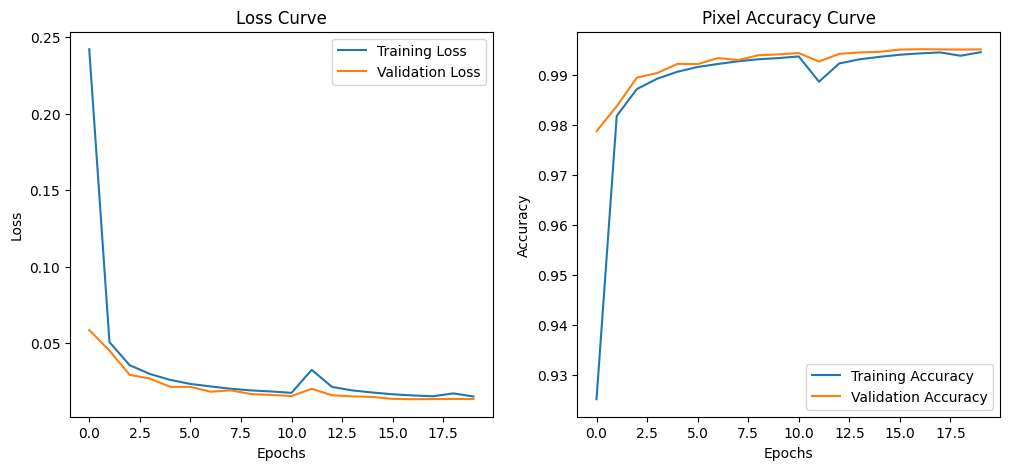

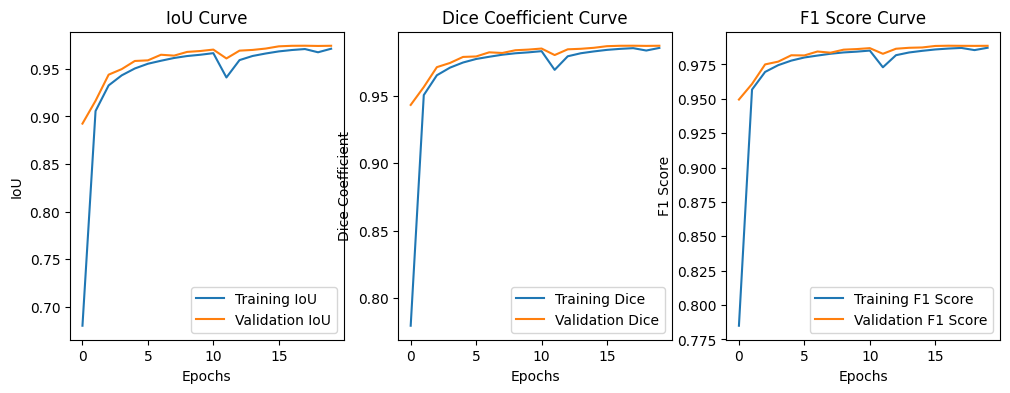

In [ ]:
# History of previous Best Model
import pickle
def analyze_progress(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['pixel_accuracy'], label='Training Accuracy')
    plt.plot(history['val_pixel_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Pixel Accuracy Curve')
    plt.legend()

    plt.show()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history['iou_coeff'], label='Training IoU')
    plt.plot(history['val_iou_coeff'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Curve')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['dice_coeff'], label='Training Dice')
    plt.plot(history['val_dice_coeff'], label='Validation Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.title('Dice Coefficient Curve')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['f1_score'], label='Training F1 Score')
    plt.plot(history['val_f1_score'], label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curve')
    plt.legend()

    plt.show()

# analysis_progress(history)
with open(prev_best+".pkl",  "rb") as f:
    curr_history= pickle.load(f)
    analyze_progress(curr_history)

# Finetuning
As model using bce_dice_loss trained for 20 epoch gives best result till now so I will finetune it with bce_iou_loss for next 20 epochs

loss: 0.0152
val_loss: 0.0135
So, I will use min delta of 0.001 with petence 5
with a insreased learning rate of 0.0005
loss= bce_dice_loss

In [ ]:
# fine tuning
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def bce_iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # ensuring float32 data type
    y_pred = tf.cast(y_pred, tf.float32)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    iou = iou_loss(y_true, y_pred)

    return 0.5 * bce + 0.5 * iou


prev_best_model= load_model(prev_best+".keras", compile=False)

optimizer = Adam(learning_rate=0.0005)

prev_best_model.compile(optimizer=optimizer,
                        loss=bce_iou_loss,
                        metrics=['accuracy', f1_score, iou_coeff, dice_coeff, pixel_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)


history_bce_iou = prev_best_model.fit(
    TRAIN_XX, TRAIN_YY,
    validation_data=(VALID_XX, VALID_YY),
    epochs=20,  # next 20 more epochs
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

gc.collect()
import pickle
folder, name= DIR+"/models/", "my_model_1_finetuned_5bce_5iou_20ep_colab"

with open(folder+ name+".pkl", "wb") as f:
    pickle.dump(history_bce_iou.history, f)

prev_best_model.save(folder+ name+ ".h5")
prev_best_model.save(folder+ name+".keras")

Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.9944 - dice_coeff: 0.9847 - f1_score: 0.9867 - iou_coeff: 0.9699 - loss: 0.0235 - pixel_accuracy: 0.9944 - val_accuracy: 0.9945 - val_dice_coeff: 0.9828 - val_f1_score: 0.9846 - val_iou_coeff: 0.9661 - val_loss: 0.0253 - val_pixel_accuracy: 0.9945
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.9950 - dice_coeff: 0.9861 - f1_score: 0.9879 - iou_coeff: 0.9726 - loss: 0.0212 - pixel_accuracy: 0.9950 - val_accuracy: 0.9941 - val_dice_coeff: 0.9820 - val_f1_score: 0.9836 - val_iou_coeff: 0.9646 - val_loss: 0.0264 - val_pixel_accuracy: 0.9941
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.9952 - dice_coeff: 0.9867 - f1_score: 0.9885 - iou_coeff: 0.9738 - loss: 0.0202 - pixel_accuracy: 0.9952 - val_accuracy: 0.9932 - val_dice_coeff: 0.9793 - val_f1_score: 0.9809 - val_iou_coeff: 0.9594 - val_loss: 0.0314 - val_pixel_accuracy: 0.9932
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/ste

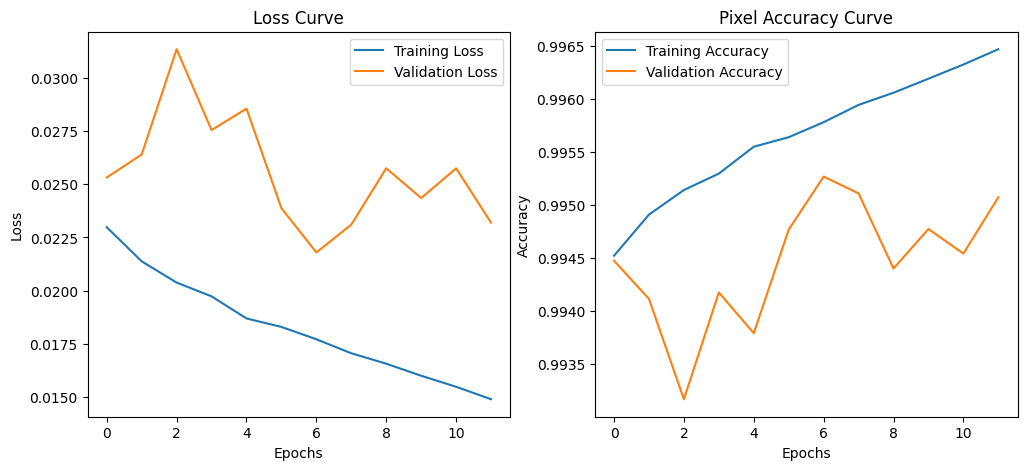

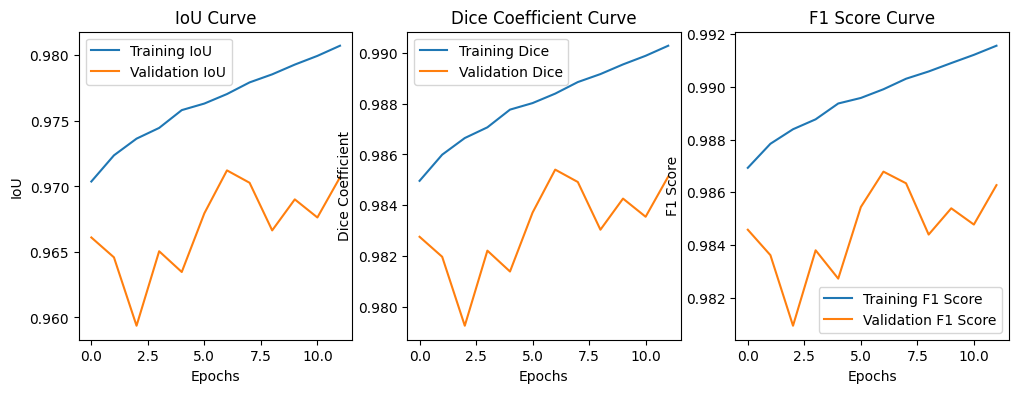

In [ ]:
with open(folder+ name+".pkl",  "rb") as f:
    curr_history= pickle.load(f)
    analyze_progress(curr_history)

### Checking prediction on validation data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
Total error pixels: 51


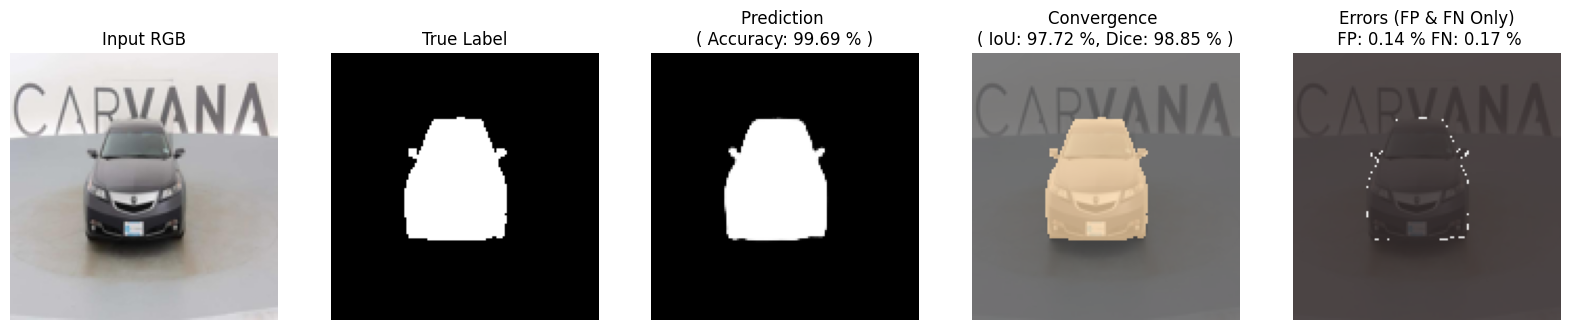

Total error pixels: 85


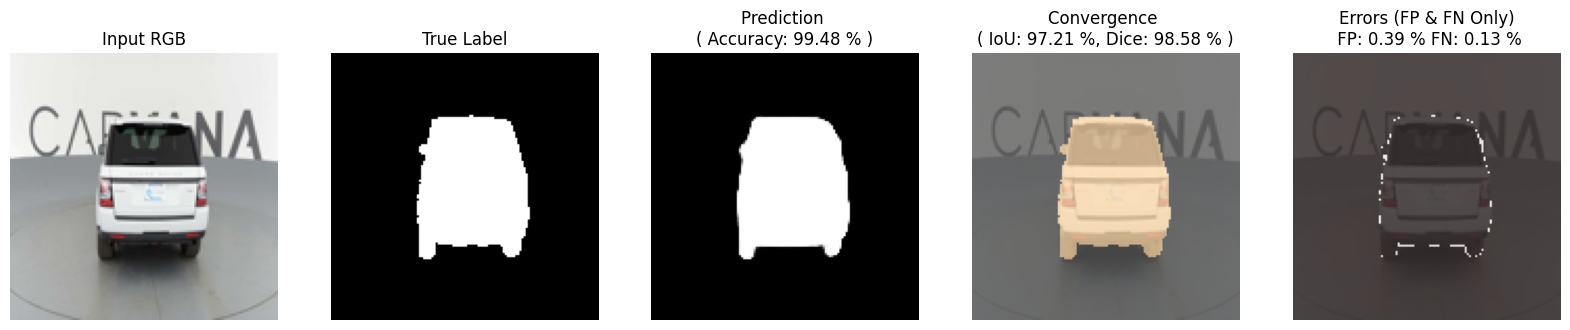

Total error pixels: 67


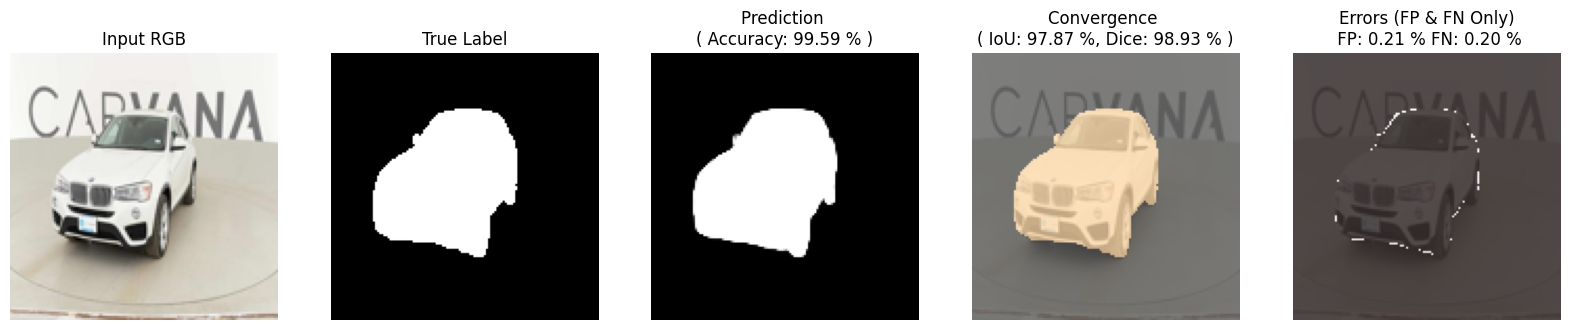

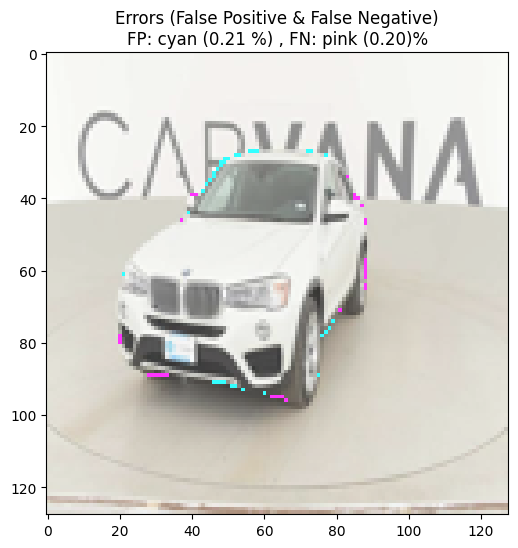

In [ ]:
def visualize_prediction(xx, yy_true, yy_pred, image=1):
    for i in range(image):
        ind = np.random.randint(0, len(xx))  # random index
        total_pix = yy_true[ind].size

        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
        ax1.set_title("Input RGB")
        ax1.imshow(xx[ind])

        ax2.set_title("True Label")
        ax2.imshow(yy_true[ind].squeeze(), cmap='gray')

        pixel_acc = pixel_accuracy(yy_true[ind], yy_pred[ind]) *100
        ax3.set_title(f"Prediction \n( Accuracy: {pixel_acc:.2f} % )")
        ax3.imshow(yy_pred[ind].squeeze(), cmap='gray')

        intersection = np.logical_and(yy_true[ind], yy_pred[ind]).astype(np.uint8)
        iou, dice= iou_coeff(yy_true[ind], yy_pred[ind])*100, dice_coeff(yy_true[ind], yy_pred[ind])*100
        ax4.set_title(f"Convergence \n( IoU: {iou:.2f} %, Dice: {dice:.2f} % )")
        ax4.imshow(xx[ind], alpha=0.5)
        ax4.imshow(intersection.squeeze(), cmap='copper', alpha=0.5) # inferno, coolwarm, copper, hot, magma, jet


        yy_pred_bin = (yy_pred[ind] > 0.5).astype(np.uint8)
        false_pos = np.logical_and(yy_true[ind] == 0, yy_pred_bin == 1) # False Positive: actually Flase & prediction True
        false_neg = np.logical_and(yy_true[ind] == 1, yy_pred_bin == 0) # False Negative: actually True & prediction False
        wrong_mask= np.logical_or(false_pos, false_neg).astype(np.uint8)
        fp, fn= np.sum(false_pos)/total_pix*100, np.sum(false_neg)/total_pix*100
        ax5.set_title(f"""Errors (FP & FN Only)\n FP: {fp:.2f} % FN: {fn:.2f} %""")

        ax5.imshow(xx[ind], alpha=0.5)
        ax5.imshow(wrong_mask.squeeze(), cmap='hot', alpha=0.7)
        # ax5.imshow(wrong_mask_.squeeze(), cmap='magma', alpha=0.7)
        print(f"Total error pixels: {np.sum(wrong_mask)}")

        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        ax5.axis('off')
        plt.show()

    error_overlay = xx[ind].copy()
    # print(error_overlay.shape, false_pos.shape)
    error_overlay[false_pos[..., 0] == 1] = [0, 255, 255]   # cine
    error_overlay[false_neg[..., 0] == 1] = [255, 0, 255]   # pink
    plt.figure(figsize=(6, 6))
    plt.title(f"Errors (False Positive & False Negative)\nFP: cyan ({fp:.2f} %) , FN: pink ({fn:.2f})%")
    plt.imshow(error_overlay, alpha=0.8)
    plt.plot()

visualize_prediction(VALID_XX[50:60], VALID_YY[50:60], prev_best_model.predict(VALID_XX[50:60]), image=3)

# Overfitting
So after 6 epoch train loss decreases but validation loss increases so model starts overfitting


In [ ]:
compute_metrics(TEST_XX, TEST_YY, model_path=folder+"my_model_1_3bce_7dice_20ep_colab.keras")
compute_metrics(TEST_XX, TEST_YY, model_path=folder+name+".keras")

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Model :  /content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_3bce_7dice_20ep_colab.keras
IoU Score: 0.9759
Dice Coefficient: 0.9878
Pixel Accuracy: 0.9948
F1-Score: 0.9948
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Model :  /content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_finetuned_5bce_5iou_20ep_colab.keras
IoU Score: 0.9787
Dice Coefficient: 0.9892
Pixel Accuracy: 0.9954
F1-Score: 0.9954



Also the new model is much better than previous best model

In [ ]:
folder+"my_model_1_3bce_7dice_20ep_colab.keras"

'/content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_3bce_7dice_20ep_colab.keras'

# Transfer Learning & Feature retention
   Using previous best model & adding Dropout and rl_schedular to encounter overfitting and minimize loss

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models

# Load the pre-trained model without compiling
fine_tuned1_model = load_model("/content/drive/MyDrive/Colab Notebooks/data/models/my_model_1_3bce_7dice_20ep_colab.keras", compile=False)

for layer in fine_tuned1_model.layers[:12]:  # retaining low-level features conv-1,2,3, 4 # while modifying layers 5, 6
    layer.trainable = False

inputs = fine_tuned1_model.input
x = fine_tuned1_model.output

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Dropout(0.2)(x)

# 256 -> 128 learnig deeper layer then refining it

x = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

modified_model = models.Model(inputs=inputs, outputs=x)


In [ ]:
modified_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_184 (Conv2D)       │ (None, 128, 128, 16)   │            448 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_185 (Conv2D)       │ (None, 128, 128, 16)   │          2,320 │ conv2d_184[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_40          │ (None, 64, 64, 16)     │              0 │ conv2d_185[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_186 (Conv2D)       │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_40[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_187 (Conv2D)       │ (None, 64, 64, 32)     │          9,248 │ conv2d_186[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_41          │ (None, 32, 32, 32)     │              0 │ conv2d_187[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_41[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 32, 32, 64)     │         36,928 │ conv2d_188[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_42          │ (None, 16, 16, 64)     │              0 │ conv2d_189[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_42[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 16, 16, 128)    │        147,584 │ conv2d_190[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_43          │ (None, 8, 8, 128)      │              0 │ conv2d_191[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)       │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_43[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_193 (Conv2D)       │ (None, 8, 8, 256)      │        590,080 │ conv2d_192[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_44          │ (None, 4, 4, 256)      │              0 │ conv2d_193[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_194 (Conv2D)  

 Total params: 8,073,330 (30.80 MB)

 Trainable params: 7,779,810 (29.68 MB)

 Non-trainable params: 293,520 (1.12 MB)

# Fine Tuning 2

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0005, decay_steps=333*4, decay_rate=0.98, staircase=True  # 4% reduction
)

optimizer = Adam(learning_rate=lr_schedule)

modified_model.compile(optimizer=optimizer,
                        loss=bce_iou_loss,
                        metrics=['accuracy', f1_score, iou_coeff, dice_coeff, pixel_accuracy])

early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.001, restore_best_weights=True)
# 12/4= 3 , waiting for 3 learning rate change

history_bce_iou2 = modified_model.fit(
    TRAIN_XX, TRAIN_YY,
    validation_data=(VALID_XX, VALID_YY),
    epochs=40,  # next 36+ more epochs
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

gc.collect()
import pickle
folder, name= DIR+"/models/", "my_model_1_finetuned2_5bce_5iou_40ep_colab"

with open(folder+ name+".pkl", "wb") as f:
    pickle.dump(history_bce_iou2.history, f)

modified_model.save(folder+ name+ ".h5")
modified_model.save(folder+ name+".keras")

Epoch 1/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 74s 159ms/step - accuracy: 0.9886 - dice_coeff: 0.8145 - f1_score: 0.9735 - iou_coeff: 0.7432 - loss: 0.2169 - pixel_accuracy: 0.9886 - val_accuracy: 0.9946 - val_dice_coeff: 0.9832 - val_f1_score: 0.9849 - val_iou_coeff: 0.9670 - val_loss: 0.0250 - val_pixel_accuracy: 0.9946
Epoch 2/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 63s 145ms/step - accuracy: 0.9949 - dice_coeff: 0.9860 - f1_score: 0.9879 - iou_coeff: 0.9724 - loss: 0.0218 - pixel_accuracy: 0.9949 - val_accuracy: 0.9950 - val_dice_coeff: 0.9843 - val_f1_score: 0.9861 - val_iou_coeff: 0.9692 - val_loss: 0.0233 - val_pixel_accuracy: 0.9950
Epoch 3/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 81s 144ms/step - accuracy: 0.9953 - dice_coeff: 0.9871 - f1_score: 0.9888 - iou_coeff: 0.9744 - loss: 0.0201 - pixel_accuracy: 0.9953 - val_accuracy: 0.9946 - val_dice_coeff: 0.9835 - val_f1_score: 0.9850 - val_iou_coeff: 0.9675 - val_loss: 0.0247 - val_pixel_accuracy: 0.9946
Epoch 4/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms

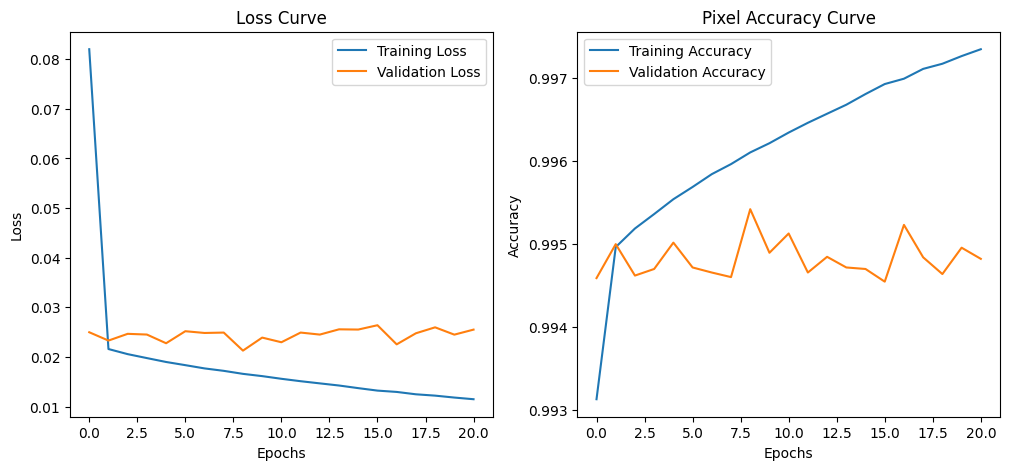

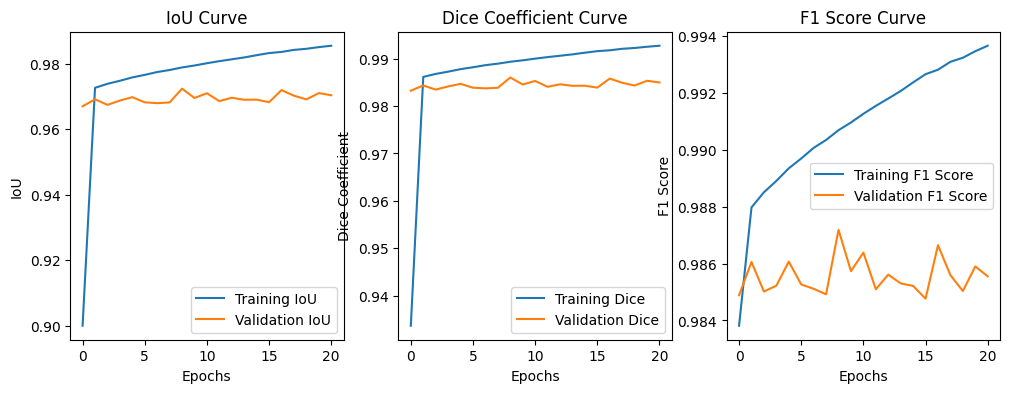

In [ ]:
with open(folder+ name+".pkl",  "rb") as f:
    curr_history= pickle.load(f)
    analyze_progress(curr_history)

#### So, we can see from the graphs that the validation loss or metrics have plateaued, thereby avoiding further training.

In [ ]:
compute_metrics(TEST_XX, TEST_YY, model_path="/content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_finetuned_5bce_5iou_20ep_colab.keras")
compute_metrics(TEST_XX, TEST_YY, model_path=folder+name+".keras")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Model :  /content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_finetuned_5bce_5iou_20ep_colab.keras
IoU Score: 0.9787
Dice Coefficient: 0.9892
Pixel Accuracy: 0.9954
F1-Score: 0.9954
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step
Model :  /content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_finetuned2_5bce_5iou_40ep_colab.keras
IoU Score: 0.9775
Dice Coefficient: 0.9886
Pixel Accuracy: 0.9952
F1-Score: 0.9952


## Training Conslusion:
 First finetuned model is best at this stage

# Evaluation

#### Loading Best model

In [ ]:
BEST_MODEL_PATH= "/content/drive/MyDrive/Colab Notebooks/data//models/my_model_1_finetuned_5bce_5iou_20ep_colab.keras"
BEST_MODEL= load_model(BEST_MODEL_PATH, compile=False)

In [ ]:
BEST_PRED= BEST_MODEL.predict(TEST_XX)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [ ]:
BEST_MODEL.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=bce_iou_loss,
    metrics=['accuracy', f1_score, iou_coeff, dice_coeff, pixel_accuracy]
)
test_results = BEST_MODEL.evaluate(TEST_XX, TEST_YY)
metric_names = BEST_MODEL.metrics_names

for name, value in zip(metric_names, test_results):
    print(f"{name}: {value:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9954 - dice_coeff: 0.9878 - f1_score: 0.9891 - iou_coeff: 0.9760 - loss: 0.0196 - pixel_accuracy: 0.9954
loss: 0.0194
compile_metrics: 0.9954


### Visualizing Segmentation

Total error pixels: 56


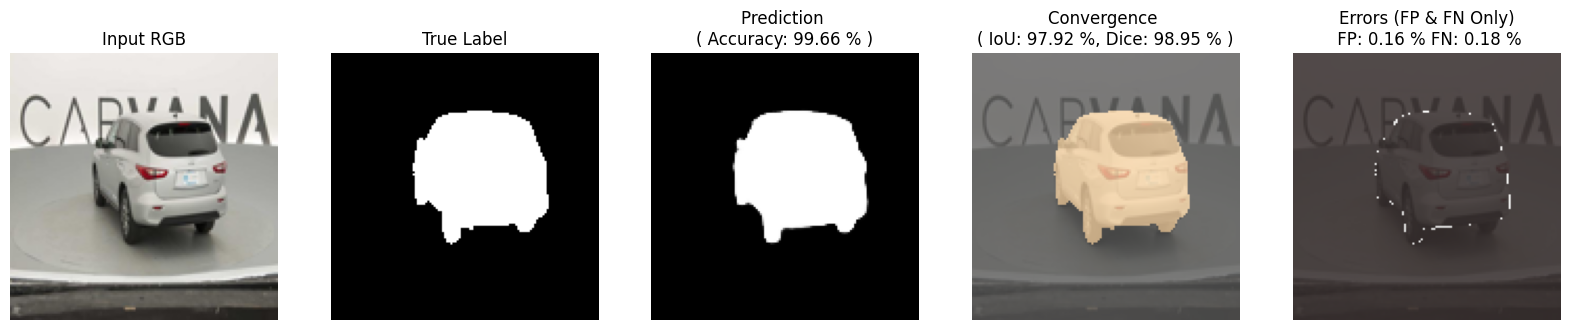

Total error pixels: 43


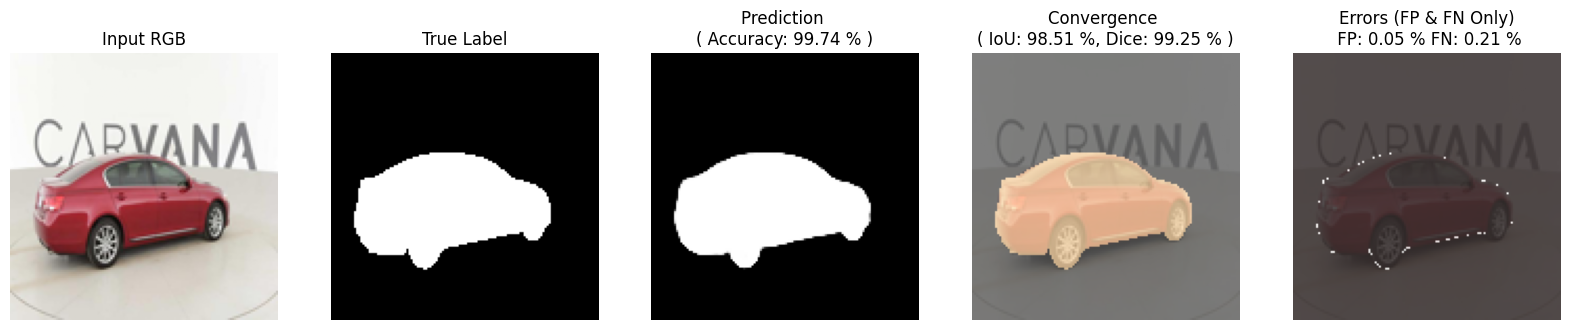

Total error pixels: 54


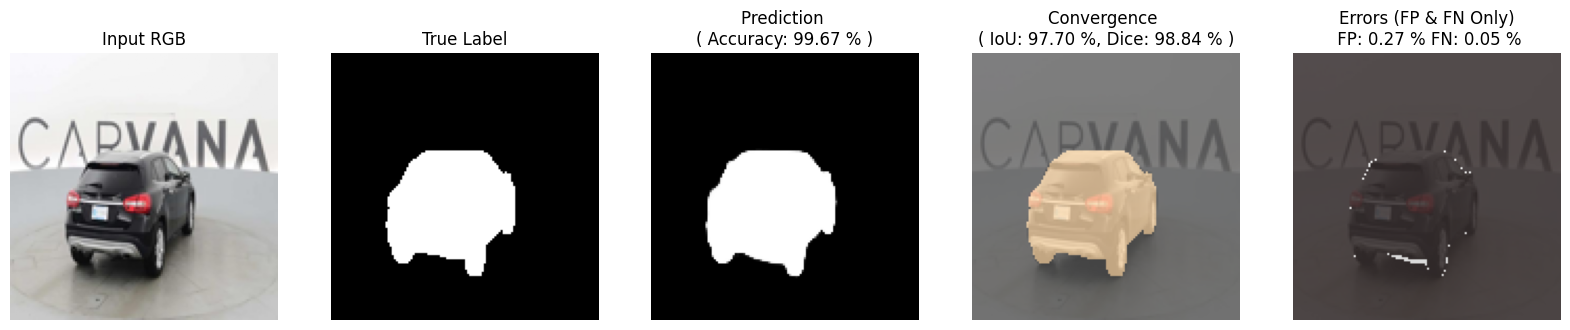

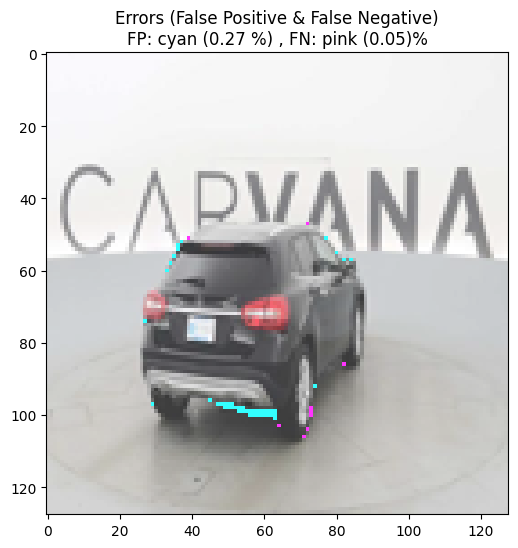

In [ ]:
def visualize_prediction(xx, yy_true, yy_pred, image=1):
    for i in range(image):
        ind = np.random.randint(0, len(xx))  # random index
        total_pix = yy_true[ind].size

        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
        ax1.set_title("Input RGB")
        ax1.imshow(xx[ind])

        ax2.set_title("True Label")
        ax2.imshow(yy_true[ind].squeeze(), cmap='gray')

        pixel_acc = pixel_accuracy(yy_true[ind], yy_pred[ind]) *100
        ax3.set_title(f"Prediction \n( Accuracy: {pixel_acc:.2f} % )")
        ax3.imshow(yy_pred[ind].squeeze(), cmap='gray')

        intersection = np.logical_and(yy_true[ind], yy_pred[ind]).astype(np.uint8)
        iou, dice= iou_coeff(yy_true[ind], yy_pred[ind])*100, dice_coeff(yy_true[ind], yy_pred[ind])*100
        ax4.set_title(f"Convergence \n( IoU: {iou:.2f} %, Dice: {dice:.2f} % )")
        ax4.imshow(xx[ind], alpha=0.5)
        ax4.imshow(intersection.squeeze(), cmap='copper', alpha=0.5) # inferno, coolwarm, copper, hot, magma, jet


        yy_pred_bin = (yy_pred[ind] > 0.5).astype(np.uint8)
        false_pos = np.logical_and(yy_true[ind] == 0, yy_pred_bin == 1) # False Positive: actually Flase & prediction True
        false_neg = np.logical_and(yy_true[ind] == 1, yy_pred_bin == 0) # False Negative: actually True & prediction False
        wrong_mask= np.logical_or(false_pos, false_neg).astype(np.uint8)
        fp, fn= np.sum(false_pos)/total_pix*100, np.sum(false_neg)/total_pix*100
        ax5.set_title(f"""Errors (FP & FN Only)\n FP: {fp:.2f} % FN: {fn:.2f} %""")

        ax5.imshow(xx[ind], alpha=0.5)
        ax5.imshow(wrong_mask.squeeze(), cmap='hot', alpha=0.7)
        # ax5.imshow(wrong_mask_.squeeze(), cmap='magma', alpha=0.7)
        print(f"Total error pixels: {np.sum(wrong_mask)}")

        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        ax5.axis('off')
        plt.show()

    error_overlay = xx[ind].copy()
    # print(error_overlay.shape, false_pos.shape)
    error_overlay[false_pos[..., 0] == 1] = [0, 255, 255]   # cine
    error_overlay[false_neg[..., 0] == 1] = [255, 0, 255]   # pink
    plt.figure(figsize=(6, 6))
    plt.title(f"Errors (False Positive & False Negative)\nFP: cyan ({fp:.2f} %) , FN: pink ({fn:.2f})%")
    plt.imshow(error_overlay, alpha=0.8)
    plt.plot()

visualize_prediction(TEST_XX, TEST_YY, BEST_PRED, image=3)